In [65]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyodbc
import sys
import urllib
from sqlalchemy import create_engine
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

In [123]:
df_sales2019 = pd.read_csv("../data/p_store_order2019.csv")
df_sales2018 = pd.read_csv("../data/p_store_order2018.csv")

In [124]:
df_sales2019.head(2)

,orderno,branch,saledate,saletime,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,20190314,1411,1,0.0,2300.0,2300.0
1,201904160001,BK0008,20190416,1224,1,0.0,3000.0,3000.0


In [125]:
# change setdate and saletime to datetime
def convert_dates(df):
    """
    converts saledate and saletime columns into one datetime datatype column
    
    Paremeters
    ==========
    df: Pandas DataFrame
    
    Returns
    =======
    df: Pandas Dataframe
        returns dataframe with new saledate column and drops old columns
    
    """
    df["saledate"] = df["saledate"].astype("str") + df["saletime"].astype("str").str.zfill(4)
    df["saledate"] = pd.to_datetime(df["saledate"], format='%Y%m%d%H%M')
    df.drop("saletime", axis=1, inplace=True)
    return df

In [126]:
# new dataframes with converted datetimes
df2019 = convert_dates(df_sales2019)
df2018 = convert_dates(df_sales2018)
df2019.head(1)

,orderno,branch,saledate,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,2019-03-14 14:11:00,1,0.0,2300.0,2300.0


In [204]:
def store_df_interval(df, interval):
    """
    Dataframe with datetime interval as rows and each store's tamount as columns.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Raw Dataframe with all stores and transactions
    interval: str
        Label of the interval used to aggregate datetimes
        
    Returns
    =======
    Pandas DataFrame
        New aggregated DataFrame of the all stores and time interval
    """
    store_df = df.set_index('saledate')[["branch", "tamount"]]
    store_df = store_df.groupby("branch").resample(interval, label='right').sum()
    store_df = store_df["tamount"].unstack(level=0)
    return store_df[1:] # drop first row (previous year sales)


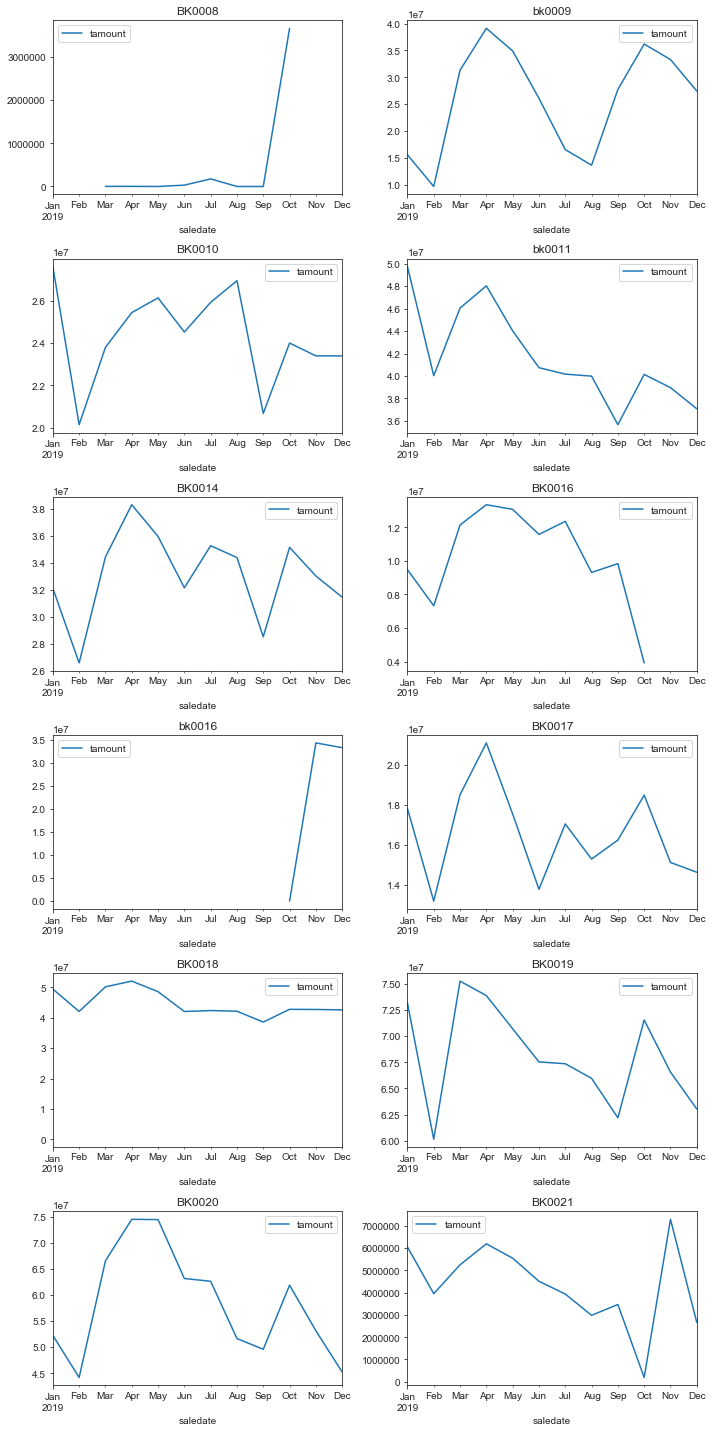

In [111]:
# plot yearly sales for each store
num_stores = df2019["branch"].unique().shape
fig, axes = plt.subplots(6, 2, figsize=(10,20))
for ax, branch in zip(axes.flatten(), df2019["branch"].unique()):
    get_store_data(df2019, branch, "M").plot(ax=ax, xlim=(588.0, 599.0))
    ax.set_title(branch)

plt.tight_layout()

In [178]:
store_df = get_store_df(df2019, "M")
store_df.head(5)

branch,BK0008,BK0010,BK0014,BK0016,BK0017,BK0018,BK0019,BK0020,BK0021,BK0022,...,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003,bk0009,bk0011,bk0016,bk0023,bk0026
saledate,,,,,,,,,,,,,,,,,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31,NaN,27616850.0,32120850.0,9476600.0,17817090.0,49449650.0,73158360.0,52265470.0,6054100.0,23664400.0,...,NaN,NaN,19933100.0,53670950.0,50362100.0,15570500.0,49746750.0,NaN,NaN,NaN
2019-02-28,NaN,20143750.0,26576150.0,7328300.0,13183010.0,42068350.0,60155120.0,44193120.0,3955050.0,20222450.0,...,NaN,NaN,14902650.0,42085450.0,42372520.0,9675100.0,40029250.0,NaN,NaN,NaN
2019-03-31,2300.0,23794500.0,34445750.0,12136200.0,18500140.0,50182400.0,75233910.0,66544330.0,5251800.0,24355050.0,...,NaN,NaN,17144000.0,63679500.0,52472420.0,31303700.0,46045450.0,NaN,NaN,NaN
2019-04-30,3000.0,25440300.0,38331200.0,13343800.0,21088580.0,52066800.0,73853400.0,74502530.0,6195200.0,27481550.0,...,NaN,NaN,20517000.0,69185050.0,57099560.0,39107450.0,48026550.0,NaN,NaN,NaN


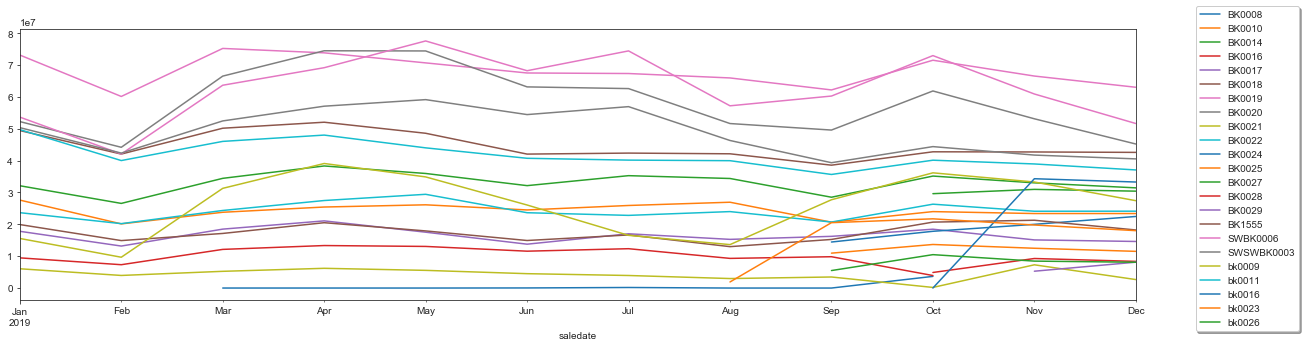

In [179]:
fig, ax = plt.subplots()
store_df[1:].plot(figsize=(20,5), legend=True, ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(1.1,1.1), shadow=True, ncol=1)


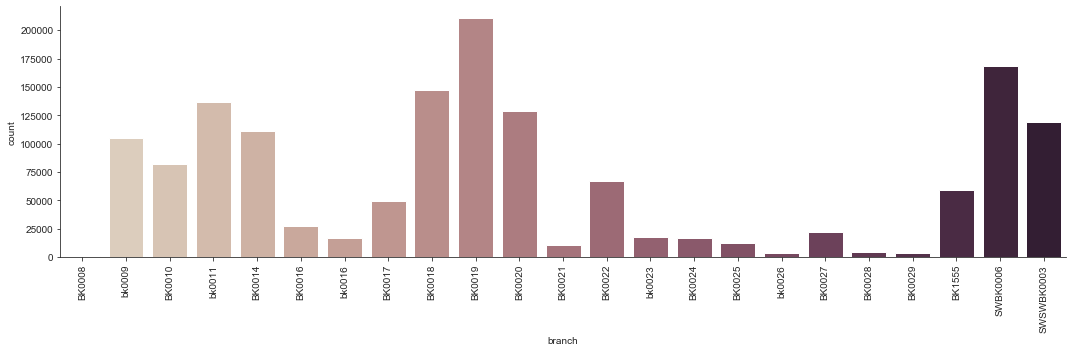

In [36]:
sns.set_style('ticks')
sns.catplot(x="branch", kind="count", palette="ch:.25", data=df, height=5, aspect=3)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [215]:
def store_df_refactor_saledate(df):
    df_new = df[["branch", "saledate", "tamount"]].copy()
    df_new["year"] = df_new["saledate"].dt.year
    df_new["month"] = df_new["saledate"].dt.month
    df_new["day"] = df_new["saledate"].dt.day
    df_new["hour"] = df_new["saledate"].dt.hour
    df_new["minute"] = df_new["saledate"].dt.minute
    value = df_new["year"].value_counts().idxmax()
    del df_new[""]
    return df_new[df_new["year"]==value] # exclude pre-year dates

In [217]:
test = store_df_refactor_saledate(df2019)
test.head()

,branch,saledate,tamount,year,month,day,hour,minute
0,BK0008,2019-03-14 14:11:00,2300.0,2019,3,14,14,11
1,BK0008,2019-04-16 12:24:00,3000.0,2019,4,16,12,24
2,BK0008,2019-06-11 17:56:00,4600.0,2019,6,11,17,56
3,BK0008,2019-06-24 17:09:00,4000.0,2019,6,24,17,9
4,BK0008,2019-06-24 17:13:00,5100.0,2019,6,24,17,13
